# Data set analysis

#### Import the input data

In [3]:
#!pip install pandas
import pandas as pd

data = pd.read_csv('data_eng.csv')

#### Input data summary

In [4]:
data.describe()

,ticket_description,expert_id
count,200,200
unique,20,10
top,Error 404 when accessing the application.,expert_4
freq,14,27


#### Check for null values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ticket_description  200 non-null    object
 1   expert_id           200 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB


#### Check validity of values

In [6]:
import re

def check_row(row):
    c1 = len(row['ticket_description'].strip()) > 0
    c2 = bool(re.match(r'^expert_\d+$', row['expert_id']))
    return c1 and c2

data_cleaned = data[data.apply(check_row, axis=1)]

data = data_cleaned.reset_index(drop=True)

data.describe()

,ticket_description,expert_id
count,200,200
unique,20,10
top,Error 404 when accessing the application.,expert_4
freq,14,27


#### Removing the duplicates

In [7]:
data = data.drop_duplicates()
data.describe()

,ticket_description,expert_id
count,124,124
unique,20,10
top,Incorrect timezone in reports.,expert_0
freq,8,16


#### Analyzing the distribution

In [8]:
unique_experts = data['expert_id'].unique()
unique_experts

array(['expert_6', 'expert_4', 'expert_5', 'expert_0', 'expert_2',
       'expert_9', 'expert_8', 'expert_1', 'expert_3', 'expert_7'],
      dtype=object)

In [9]:
distribution_experts = data['expert_id'].value_counts()
distribution_experts

expert_id
expert_0    16
expert_4    15
expert_2    15
expert_8    14
expert_3    13
expert_5    12
expert_1    11
expert_9    10
expert_6     9
expert_7     9
Name: count, dtype: int64

#### Plot the distribution

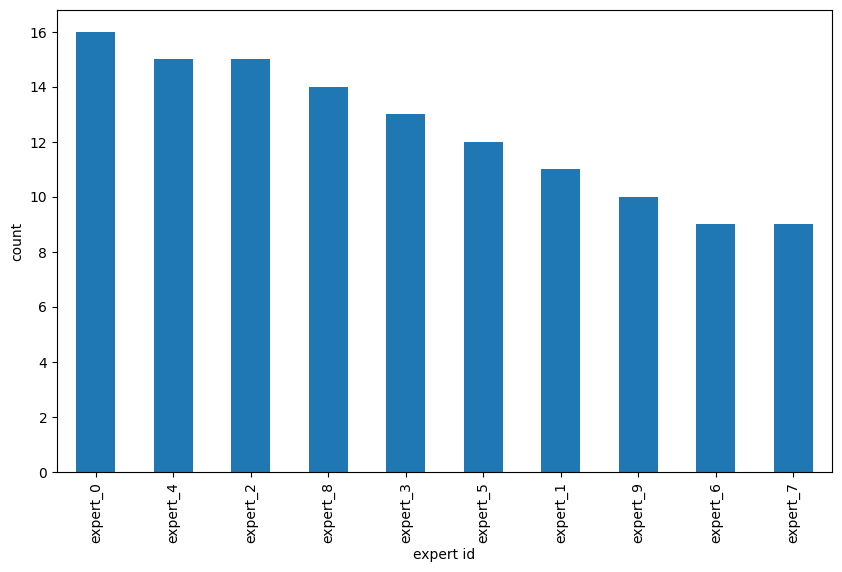

In [10]:
import matplotlib.pyplot as plt

distribution_experts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('expert id')
plt.ylabel('count')
plt.show()

##### There is no significance class imbalance

# Base model: Bayes classification

#### Split the data into train and test

In [11]:
import random
import numpy as np

def assign_train_test_split(df, train_ratio=0.8):
    df1 = df.copy()
    random_numbers = np.random.rand(len(df1))
    df1['split'] = np.where(random_numbers <= train_ratio, 'train', 'test')
    return df1

data = assign_train_test_split(data)

In [12]:
data.value_counts('split', normalize=True)

split
train    0.75
test     0.25
Name: proportion, dtype: float64

##### The train label is 100/124 ~ 80%

In [13]:
#!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [14]:
def get_tfidf_vectors_and_labels(df, split="train", vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=100)
    if split == "train":
        vectorizer.fit(df[df.split == split]['ticket_description'])
    vectors = vectorizer.transform(df[df.split == split]['ticket_description'])
    labels = df[df.split == split]['expert_id']
    return vectors.toarray(), labels, vectorizer

In [15]:
def do_tfidf_prediction(df, max_features, model='nb'):
    vectorizer = TfidfVectorizer(max_features=max_features)
    vectors_train, labels_train, vectorizer = get_tfidf_vectors_and_labels(df, split="train", vectorizer=vectorizer)
    vectors_test, labels_test, _ = get_tfidf_vectors_and_labels(df, split="test", vectorizer=vectorizer)
    
    if model == 'nb':
        classifier = MultinomialNB().fit(vectors_train, labels_train)
    else:
        classifier = LogisticRegression().fit(vectors_train, labels_train)
    
    predicted_train = classifier.predict(vectors_train)
    predicted_test = classifier.predict(vectors_test)
    f1_train = f1_score(labels_train, predicted_train, average='macro')
    f1_test = f1_score(labels_test, predicted_test, average='macro')
    accuracy = (predicted_test == labels_test).sum() / len(predicted_test)
    return f1_train, f1_test, accuracy

In [16]:
f1_train, f1_test, accuracy = do_tfidf_prediction(data, max_features = 10)
f1_train, f1_test, accuracy

(np.float64(0.13352257069904128),
 np.float64(0.01818181818181818),
 np.float64(0.03225806451612903))

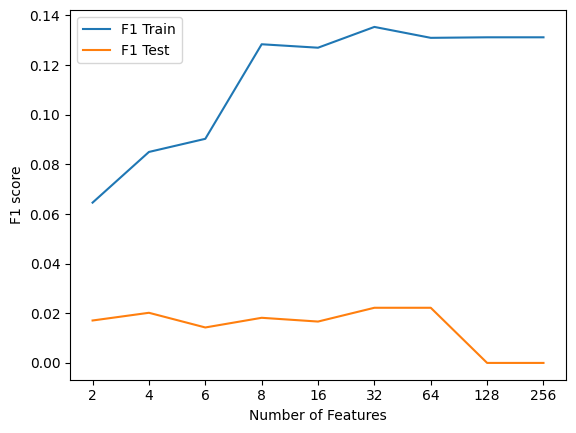

In [17]:
f1_scores_train = []
f1_scores_valid = []
max_features_array = [2, 4, 6, 8, 16, 32, 64, 128, 256]
for max_features in max_features_array:
    f1_train, f1_valid, acc = do_tfidf_prediction(data, max_features = max_features)
    f1_scores_train.append(f1_train)
    f1_scores_valid.append(f1_valid)

plt.plot(np.arange(len(max_features_array)),f1_scores_train,label="F1 Train")
plt.plot(np.arange(len(max_features_array)),f1_scores_valid,label="F1 Test")
plt.xticks(np.arange(len(max_features_array)),max_features_array)
plt.xlabel("Number of Features")
plt.ylabel("F1 score")
plt.legend()

# First model: BERT